In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

import glob
import xarray as xr
import datetime

In [2]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# set this up to point to the libararies directory in ml-holodec
dirP_str = os.path.join(os.environ['HOME'], 
                    'Python', 
                    'holodec-ml',
                    'library')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [4]:
import torch_optics_utils as optics

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


# Select Data

In [6]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [7]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [8]:
f_sel = 37 
dataFile = file_list[f_sel]

In [9]:
h_ds = xr.open_dataset(dataFile)

In [10]:
h_ds

<xarray.Dataset>
Dimensions:  (hologram_number: 100, particle: 50000, xsize: 4872, ysize: 3248)
Dimensions without coordinates: hologram_number, particle, xsize, ysize
Data variables:
    hid      (particle) float32 ...
    d        (particle) float32 ...
    x        (particle) float32 ...
    y        (particle) float32 ...
    z        (particle) float32 ...
    n0       (particle) float32 ...
    mu       (particle) float32 ...
    lam      (particle) float32 ...
    distid   (particle) float32 ...
    image    (hologram_number, xsize, ysize) uint8 ...
Attributes: (12/29)
    DateCreated:           01-Jul-2021
    Nx:                    4872.0
    Ny:                    3248.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    makeRandParts:         1
    should_random:         1
    should_extend_domain:  0
    superSamplingRate:     1.0
    monodisperse:          0.0
    should_cache:          1

Define the tile size and stride

In [11]:
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile

# step_size is not allowed be be larger than the tile_size
assert tile_size >= step_size

Define the z bin resolution

In [12]:
n_bins = 100  # number of bins in histogram
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins+1)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers

## Load physical information about the hologram

In [13]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [14]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [15]:
# create the frequency axes on the "device" needed for the reconstruction calculation
fx = torch.fft.fftfreq(Nx,dx,device=device).unsqueeze(0).unsqueeze(2)
fy = torch.fft.fftfreq(Ny,dy,device=device).unsqueeze(0).unsqueeze(1)

In [16]:
# create histogram bins
tile_x_bins = np.arange(-Nx//2,Nx//2,step_size)*dx*1e6
tile_y_bins = np.arange(-Ny//2,Ny//2,step_size)*dy*1e6

In [17]:
def get_next_hologram(h_ds,part_per_holo,empt_per_holo,max_holograms=None):
    """
    Generator to build a dataset of hologram patches
    h_ds - xarray dataset of the original hologram
    part_per_holo - number of particles with particles to get from each hologram
    empt_per_holo - number of empty patches to grab from each hologram
    max_holograms - the maximum number of holograms to load
    """
    if max_holograms is None:
        max_holograms = h_ds.dims['hologram_number']
    for h_idx in range(max_holograms):
        sub_label,sub_image,image_index_lst,image_coords = get_reconstructed_sub_images(h_idx,h_ds,part_per_holo,empt_per_holo)
        yield sub_label,sub_image,image_index_lst,image_coords
        

In [21]:
def get_reconstructed_sub_images(h_idx,h_ds,part_per_holo,empt_per_holo):
    """
    Reconstruct a hologram at specific planes to provide training data
    with a specified number of sub images containing and not containing
    particles
    """
    
    # locate particle information corresponding to this hologram
    particle_idx = np.where(h_ds['hid'].values==h_idx+1)
    
    x_part = h_ds['x'].values[particle_idx]
    y_part = h_ds['y'].values[particle_idx]
    z_part = h_ds['z'].values[particle_idx]
    d_part = h_ds['d'].values[particle_idx]  # not used but here it is
    
    # create a 3D histogram 
    in_data = np.stack((x_part,y_part,z_part)).T
    h_part = np.histogramdd(in_data,bins=[tile_x_bins,tile_y_bins,z_bins])[0]
    
    # smoothing kernel accounts for overlapping subimages when the 
    # subimage is larger than the stride
    if step_size < tile_size:
        overlap_kernel = np.ones((tile_size//step_size,tile_size//step_size))
        for z_idx in range(h_part.shape[-1]):
            h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1]
    
    # locate all the cases where particles are and are not present
    # to sample from those cases
    if step_size < tile_size:
        # note that the last bin is ommitted from each to avoid edge cases where
        # the image is not complete

        edge_idx = tile_size//step_size-1

        # find the locations where particles are in focus
        loc_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] > 0)
        # find locations where particles are not in focus
        empt_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] == 0)
    else:
        # find the locations where particles are in focus
        loc_idx = np.where(h_part > 0)
        # find locations where particles are not in focus
        empt_idx = np.where(h_part == 0)
        
    # select sub images with particles in them
    if part_per_holo > loc_idx[0].size:
        # pick the entire set
        loc_x_idx = loc_idx[0]
        loc_y_idx = loc_idx[1]
        loc_z_idx = loc_idx[2]
    else:
        # randomly select particles from the set
        sel_part_idx = np.random.choice(np.arange(loc_idx[0].size,dtype=int), size=part_per_holo, replace=False)
        loc_x_idx = loc_idx[0][sel_part_idx]
        loc_y_idx = loc_idx[1][sel_part_idx]
        loc_z_idx = loc_idx[2][sel_part_idx]

    # randomly select empties from the empty set
    sel_empt_idx = np.random.choice(np.arange(empt_idx[0].size,dtype=int), size=empt_per_holo, replace=False)
    empt_x_idx = empt_idx[0][sel_empt_idx]
    empt_y_idx = empt_idx[1][sel_empt_idx]
    empt_z_idx = empt_idx[2][sel_empt_idx]
    
    # full set of plane indices to reconstruct (empty and with particles)
    z_full_idx = np.unique(np.concatenate((loc_z_idx,empt_z_idx)))
    
    # build the torch tensor for reconstruction
    z_plane = torch.tensor(z_centers[z_full_idx]*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)
    
    # create the torch tensor for propagation
    E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)
    
    # reconstruct the selected planes
    E_out = optics.torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()
    
    # grab the sub images corresponding to the selected data points
    particle_in_focus_lst = []  # training labels for if particle is in focus
    image_lst = []  # sliced reconstructed image
    image_index_lst = []  # indices used to identify the image slice
    image_corner_coords = []  # coordinates of the corner of the image slice

    for sub_idx,z_idx in enumerate(z_full_idx):
        part_set_idx = np.where(loc_z_idx == z_idx)[0]
        empt_set_idx = np.where(empt_z_idx == z_idx)[0]

        for part_idx in part_set_idx:
            x_idx = loc_x_idx[part_idx]
            y_idx = loc_y_idx[part_idx]
            image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            image_index_lst.append([x_idx,y_idx,z_idx])
            image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
            particle_in_focus_lst.append(1)

        for empt_idx in empt_set_idx:
            x_idx = empt_x_idx[empt_idx]
            y_idx = empt_y_idx[empt_idx]
            image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            image_index_lst.append([x_idx,y_idx,z_idx])
            image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
            particle_in_focus_lst.append(0)
            
    return particle_in_focus_lst, image_lst, image_index_lst, image_corner_coords
    
    

# Demo Data Loader

In [27]:
holo_tiles = get_next_hologram(h_ds,5,5,max_holograms=1)

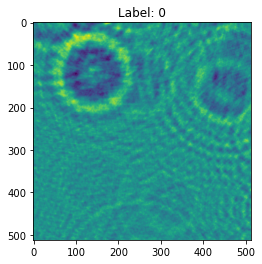

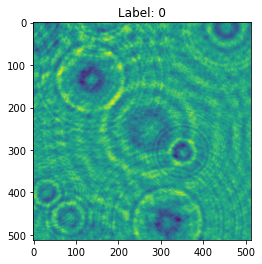

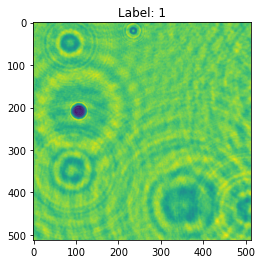

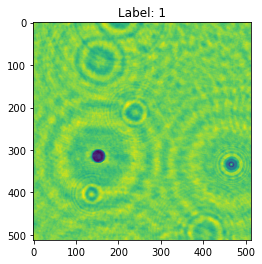

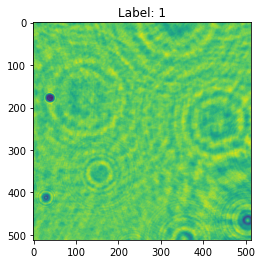

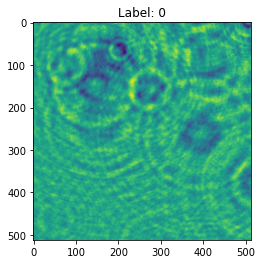

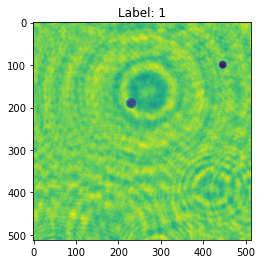

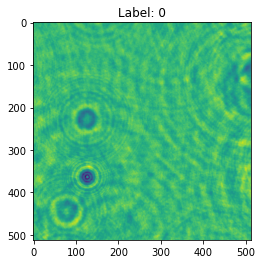

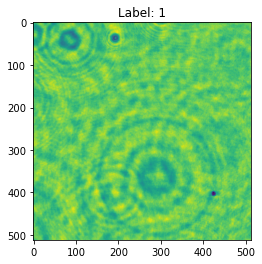

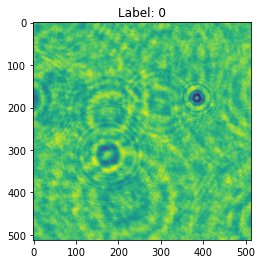

In [28]:
for data in holo_tiles:
    for idx in range(len(data[0])):
        plt.figure()
        plt.imshow(np.abs(data[1][idx]))
        plt.title(f"Label: {data[0][idx]}")
    

# Sandbox Section

In [187]:
h_idx = 10

In [188]:
particle_idx = np.where(h_ds['hid'].values==h_idx+1)

In [189]:
x_part = h_ds['x'].values[particle_idx]
y_part = h_ds['y'].values[particle_idx]
z_part = h_ds['z'].values[particle_idx]
d_part = h_ds['d'].values[particle_idx]  # not used but here it is

Create a 3D histogram

In [234]:
in_data = np.stack((x_part,y_part,z_part)).T

In [235]:
h_part = np.histogramdd(in_data,bins=[tile_x_bins,tile_y_bins,z_bins])[0]

In [236]:
h_part.shape

(38, 25, 100)

In [237]:
# If the sub images are larger than the stride, we need to spread out the positive
# instances in x and y.
if step_size < tile_size:
    overlap_kernel = np.ones((tile_size//step_size,tile_size//step_size))
    for z_idx in range(h_part.shape[-1]):
        h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1] #[:h_part.shape[0],:h_part.shape[1]]  # [tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1]

Find planes with and without particles

In [238]:
part_per_holo = 5  # number of particles to return
empt_per_holo = 5  # number of empties to return

In [239]:
z_part_bin_idx = np.digitize(z_part,z_bins)-1

In [240]:
if step_size < tile_size:
    # note that the last bin is ommitted from each to avoid edge cases where
    # the image is not complete
    
    edge_idx = tile_size//step_size-1

    # find the locations where particles are in focus
    loc_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] > 0)
    # find locations where particles are not in focus
    empt_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] == 0)
else:
    # find the locations where particles are in focus
    loc_idx = np.where(h_part > 0)
    # find locations where particles are not in focus
    empt_idx = np.where(h_part == 0)



In [241]:
# select sub images with particles in them
if part_per_holo > loc_idx[0].size:
    # pick the entire set
    loc_x_idx = loc_idx[0]
    loc_y_idx = loc_idx[1]
    loc_z_idx = loc_idx[2]
else:
    # randomly select particles from the set
    sel_part_idx = np.random.choice(np.arange(loc_idx[0].size,dtype=int), size=part_per_holo, replace=False)
    loc_x_idx = loc_idx[0][sel_part_idx]
    loc_y_idx = loc_idx[1][sel_part_idx]
    loc_z_idx = loc_idx[2][sel_part_idx]
    
# randomly select empties from the set
sel_empt_idx = np.random.choice(np.arange(empt_idx[0].size,dtype=int), size=empt_per_holo, replace=False)
empt_x_idx = empt_idx[0][sel_empt_idx]
empt_y_idx = empt_idx[1][sel_empt_idx]
empt_z_idx = empt_idx[2][sel_empt_idx]

In [242]:
# full set of plane indices to reconstruct
z_full_idx = np.unique(np.concatenate((loc_z_idx,empt_z_idx)))

In [243]:
# build the torch tensor for reconstruction
z_plane = torch.tensor(z_centers[z_full_idx]*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)

In [244]:
# create the torch tensor for propagation
E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)

In [245]:
# reconstruct the selected planes
E_out = optics.torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

In [246]:
# grab the sub images corresponding to the selected data points
particle_in_focus_lst = []  # training labels for if particle is in focus
image_lst = []  # sliced reconstructed image
image_index_lst = []  # indices used to identify the image slice
image_corner_coords = []  # coordinates of the corner of the image slice

for sub_idx,z_idx in enumerate(z_full_idx):
    part_set_idx = np.where(loc_z_idx == z_idx)[0]
    empt_set_idx = np.where(empt_z_idx == z_idx)[0]
    
    for part_idx in part_set_idx:
        x_idx = loc_x_idx[part_idx]
        y_idx = loc_y_idx[part_idx]
        image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
        image_index_lst.append([x_idx,y_idx,z_idx])
        image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
        particle_in_focus_lst.append(1)
        
    for empt_idx in empt_set_idx:
        x_idx = empt_x_idx[empt_idx]
        y_idx = empt_y_idx[empt_idx]
        image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
        image_index_lst.append([x_idx,y_idx,z_idx])
        image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
        particle_in_focus_lst.append(0)
    

In [247]:
# diagnostic for looking at particles in particular z planes
z_part_bin_idx = np.digitize(z_part,z_bins)-1

In [248]:
loc_z_idx

array([43, 77, 32, 44, 94])

In [249]:
z_centers.shape

(100,)

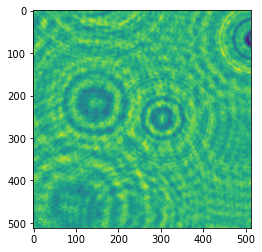

In [250]:
plt.figure()
plt.imshow(np.abs(image_lst[0]))

Label: 1


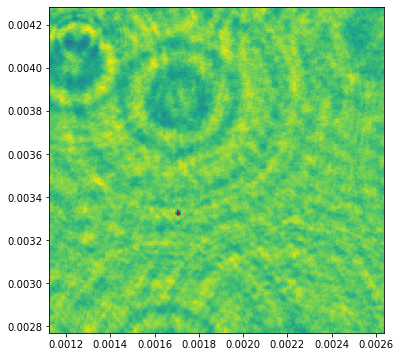

In [263]:
sub_idx = 9
x_sub_arr = np.arange(tile_size)*dx
y_sub_arr = np.arange(tile_size)*dy
plane_idx = image_index_lst[sub_idx][2]

plt_idx = np.where(z_part_bin_idx==plane_idx)[0]


fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.pcolormesh(image_corner_coords[sub_idx][0]+x_sub_arr,image_corner_coords[sub_idx][1]+y_sub_arr,np.abs(image_lst[sub_idx]).T)
ax.scatter(x_part[plt_idx]*1e-6,y_part[plt_idx]*1e-6,s=2,c='r')
ax.set_xlim([image_corner_coords[sub_idx][0],image_corner_coords[sub_idx][0]+x_sub_arr[-1]])
ax.set_ylim([image_corner_coords[sub_idx][1],image_corner_coords[sub_idx][1]+y_sub_arr[-1]])
# ax.pcolormesh(tile_x_bins*1e-6,tile_y_bins*1e-6,plt_mask.T,alpha=0.3)
print(f"Label: {particle_in_focus_lst[sub_idx]}")

In [252]:
particle_in_focus_lst

[0, 1, 0, 0, 1, 1, 0, 1, 0, 1]

In [253]:
h_ds.dims['hologram_number']

100

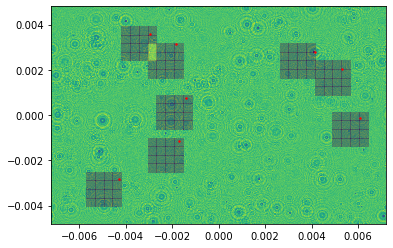

In [254]:
sub_idx = 1

plane_idx = image_index_lst[sub_idx][2]

plt_idx = np.where(z_part_bin_idx==plane_idx)[0]

plt_mask = h_part[:,:,z_full_idx[sub_idx]].copy()
plt_mask[plt_mask == 0] = np.nan

fig,ax = plt.subplots(1,1)
ax.pcolormesh(x_arr,y_arr,np.abs(E_out[sub_idx,:,:]).T)
ax.pcolormesh(tile_x_bins*1e-6,tile_y_bins*1e-6,plt_mask.T,alpha=0.3)
ax.scatter(x_part[plt_idx]*1e-6,y_part[plt_idx]*1e-6,s=2,c='r')
# ax.set_xlim([0.005,0.007])
# ax.set_ylim([0.001,0.003])

In [72]:
E_out.shape

(9, 4872, 3248)

In [75]:
z_full_idx

array([10, 13, 20, 76, 81, 84, 88, 94, 98])

In [108]:
plane_idx = 42

In [109]:
z_plane = torch.tensor([z_centers[plane_idx]*1e-6],device=device).unsqueeze(-1).unsqueeze(-1)

In [110]:
E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)

In [111]:
focus_plane = optics.torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

In [112]:
h_full = convolve2d(h_part[0][:,:,plane_idx],overlap_kernel)[:h_part[0].shape[0],:h_part[0].shape[1]]

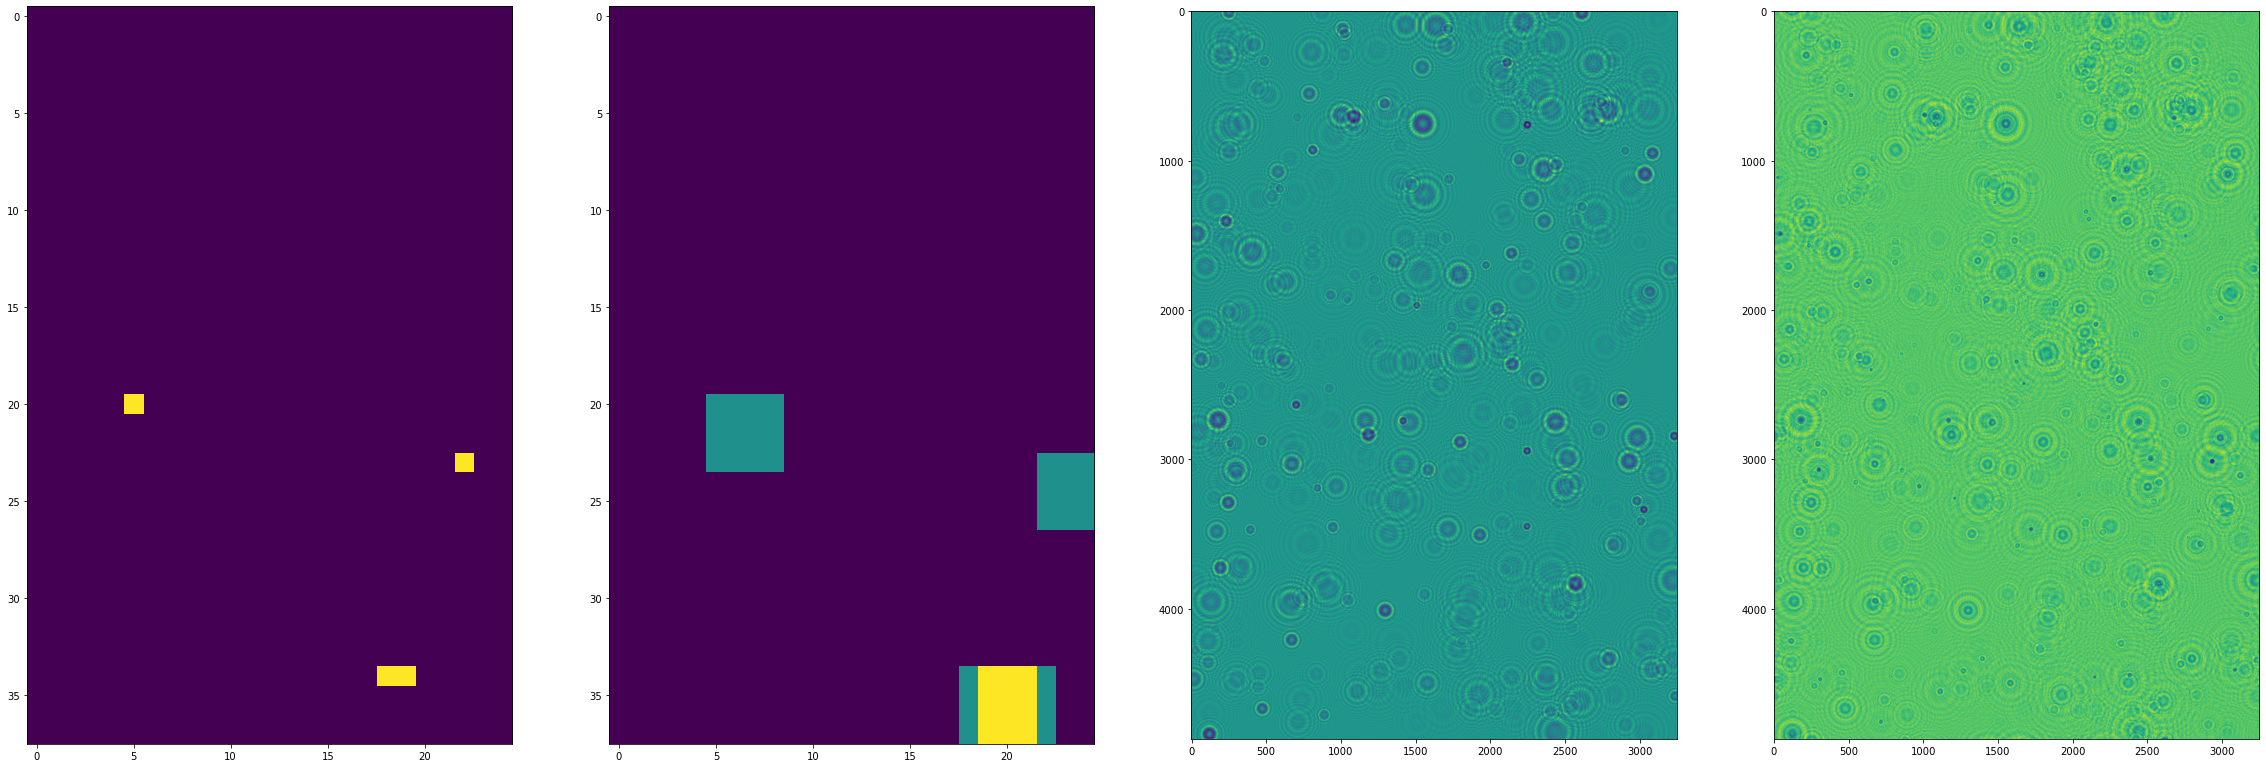

In [113]:
fig,ax = plt.subplots(1,4,figsize=(40,20))
ax[0].imshow(h_part[0][:,:,plane_idx])
ax[1].imshow(h_full)
ax[2].imshow(h_ds['image'].isel(hologram_number=h_idx).values)
ax[3].imshow(np.abs(focus_plane[0,:,:]))

(0.001, 0.003)

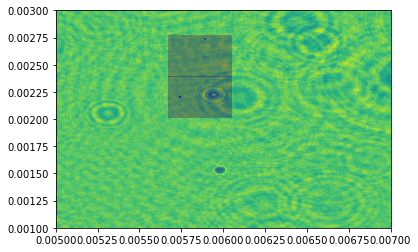

In [117]:
plt_mask = h_part[0][:,:,plane_idx].copy()
plt_mask[plt_mask == 0] = np.nan

fig,ax = plt.subplots(1,1)
ax.pcolormesh(x_arr,y_arr,np.abs(focus_plane[0,:,:]).T)
ax.pcolormesh(tile_x_bins*1e-6,tile_y_bins*1e-6,plt_mask.T,alpha=0.3)
ax.set_xlim([0.005,0.007])
ax.set_ylim([0.001,0.003])

In [ ]:
h, w = arr.shape
np.abs(focus_plane[0,:,:]).reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols)

In [118]:
focus_plane.shape

(1, 4872, 3248)

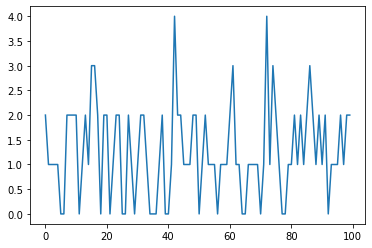

In [31]:
plt.figure()
plt.plot(np.sum(np.sum(h_part[0],axis=0),axis=0))

In [60]:
dx

2.96e-06

In [94]:
focus_plane.shape

(1, 4872, 3248)